'''
데이터 세트는 일상 사용 시 무거운 Scania 트럭에서 수집된 데이터로 구성된다. 
이 시스템은 공기압 시스템(APS)으로, 제동 및 기어 변속과 같은 대차의 다양한 기능에 사용되는 가압 공기를 생성합니다. 
데이터 세트의 pos는 APS 시스템의 특정 구성 요소에 대한 구성 요소 장애로 구성됩니다. 
neg는 APS와 관련이 없는 구성 요소에 대한 고장이 있는 트럭으로 구성됩니다. 
데이터는 전문가들이 선택한 사용 가능한 모든 데이터의 하위 집합으로 구성됩니다.

학습 데이터 6만개 / 테스트 데이터 1만 6천개

'''

In [2]:
import os
import numpy as np
import copy
from scipy import interpolate
import matplotlib.pyplot as plt
import pandas as pd

# 1. Preprocessing

In [5]:
PATH = "C:/Users/maeng/desktop/APS"
TRAIN_PATH = os.path.join(PATH, "aps_failure_training_set.csv")
TEST_PATH  = os.path.join(PATH, "aps_failure_test_set.csv")

train_data = pd.read_csv(TRAIN_PATH)
test_data  = pd.read_csv(TEST_PATH)

#결측값 처리
train_data[train_data == "na"] = np.nan
test_data[test_data == "na"]   = np.nan

idx = pd.isna(train_data).sum(axis = 0)
idx = idx[idx >= 5000].index

train_data = train_data[[i for i in train_data.columns if i not in idx]]
train_data = train_data.dropna()
test_data  = test_data[[i for i in test_data.columns if i not in idx]]
test_data  = test_data.dropna()


train_data = pd.concat([train_data.iloc[:, 1:], train_data.iloc[:, 0]], axis = 1)
test_data  = pd.concat([test_data.iloc[:, 1:], test_data.iloc[:, 0]], axis = 1)
train_data.columns = list(train_data.columns[:-1]) + ["label"]
test_data.columns = list(test_data.columns[:-1]) + ["label"]

idx = {"neg" : 0, "pos" : 1}
train_data["label"] = train_data["label"].replace(idx)
test_data["label"]  = test_data["label"].replace(idx)

train_data = train_data.astype(float)
test_data = test_data.astype(float)

In [6]:
#학습시간 단축을 위해 정상 데이터는 10%만 랜덤 샘플링, 비정상 데이터는 전체를 다 쓰도록 설정
train_data1 = pd.concat([train_data[train_data.label == 0].sample(frac = 0.1, replace = False), train_data[train_data.label == 1]]).reset_index(drop = True)
test_data1 = copy.copy(test_data)

# 2. Modeling Data

In [7]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

X_train = train_data1.iloc[:, 0:-1]; Y_train = train_data1.iloc[:,-1]; X_test = test_data1.iloc[:, 0:-1]; Y_test = test_data1.iloc[:,-1] 

# 3. Adaboost
#### 파라미터 참조 : https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html

In [15]:
from sklearn.ensemble import AdaBoostClassifier

params = {"n_estimators" : [50, 100, 150], "learning_rate" : [1]}

model_Ada = AdaBoostClassifier()
grid_model_Ada = GridSearchCV(model_Ada, param_grid = params, cv = 5, refit = True, return_train_score= True)

grid_model_Ada.fit(X_train, Y_train)

result = pd.DataFrame(grid_model_Ada.cv_results_)

best_model_Ada = grid_model_Ada.best_estimator_

In [16]:
print("CV score")
result[["params"] + ["split" + str(i) + "_test_score" for i in range(5)] + ["std_test_score", "mean_test_score"]]

CV score


,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score
0,"{'learning_rate': 1, 'n_estimators': 50}",0.974048,0.978374,0.972318,0.987889,0.982684,0.979063
1,"{'learning_rate': 1, 'n_estimators': 100}",0.982699,0.979239,0.975779,0.988754,0.983550,0.982004
2,"{'learning_rate': 1, 'n_estimators': 150}",0.981834,0.980969,0.980104,0.986159,0.982684,0.982350


In [17]:
print("Adaboost")
print("Best Parameter : " + str(grid_model_Ada.best_params_))

pred = best_model_Ada.predict(X_test)
tab = pd.crosstab(Y_test, pred, rownames = ["real"], colnames = ["pred"])
print(tab)
print("Acc : " + str((tab.iloc[0, 0] + tab.iloc[1,1]) / len(X_test)))

Adaboost
Best Parameter : {'learning_rate': 1, 'n_estimators': 150}
pred    0.0  1.0
real            
0.0   14129  123
1.0      24  136
Acc : 0.9898001665278934


# 4. Feature Importance (Top10)

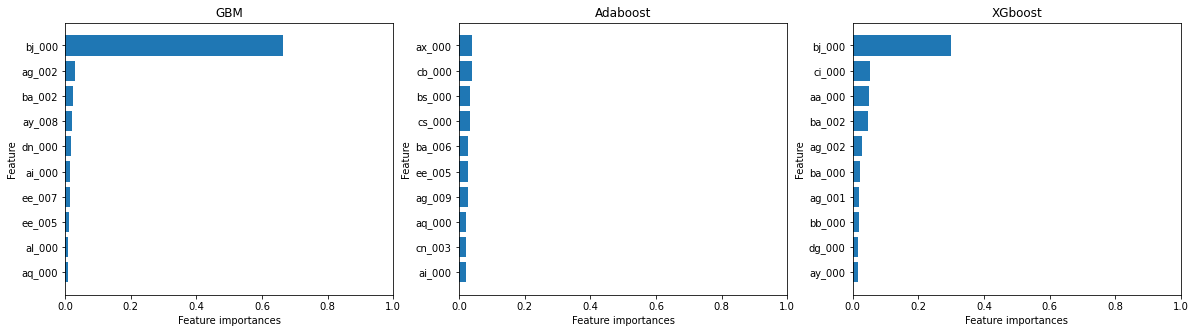

In [25]:
plt.figure(figsize = (20, 5))

plt.title("Adaboost")
fi = best_model_Ada.feature_importances_
idx = (-fi).argsort()[0:10]
fi = fi[idx]
idx = X_train.columns[idx]
plt.barh(range(10), fi[::-1], align='center')
plt.xlim(0, 1)
plt.yticks(range(10), idx[::-1])
plt.xlabel('Feature importances', size=10)
plt.ylabel('Feature', size=10)

plt.show() 